In [0]:
#reduced batch size to 32
#do data augmentation

In [0]:
#mount google drive to access data
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'impact/'

#unzip data into the main folder
!unzip -qq ./gdrive/My\ Drive/impact/tiny-imagenet-200.zip

#run the model script the initialize it
%run ./gdrive/My\ Drive/impact/resnet.ipynb

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import math

plt.ion()

Mounted at /content/gdrive
replace tiny-imagenet-200/words.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace tiny-imagenet-200/wnids.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Pad(4, padding_mode='reflect'),
        transforms.RandomResizedCrop(64),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.48, 0.448, 0.398], [0.276, 0.268, 0.280])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.48, 0.448, 0.398], [0.276, 0.268, 0.280])
    ]),
}

#read the data
data_dir = 'tiny-imagenet-200'
image_datasets = {x: torchvision.datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

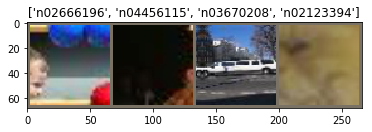

In [0]:
#script taken from pytorch.org
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.48, 0.448, 0.398])
    std = np.array( [0.276, 0.268, 0.280])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:4])

imshow(out, title=[class_names[x] for x in classes[:4]])

In [0]:
#script taken from pytorch.org
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
#an lr finder module based on leslie smith's one cycle policy
%run ./gdrive/My\ Drive/impact/lr_finder.py

<Figure size 432x288 with 0 Axes>

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


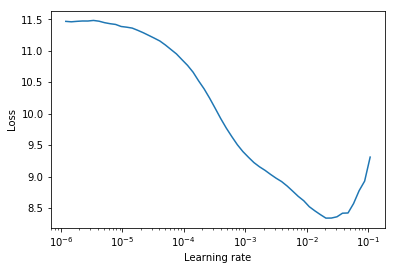

In [0]:
#find the best learning rate
model = Resnet(BasicBlock,[5,5,5])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-4)
#optimizer = optim.SGD(model.parameters(), lr=1e-5, weight_decay=1e-3,momentum=0.85)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(dataloaders['train'], end_lr=100, num_iter=100)
lr_finder.plot()

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


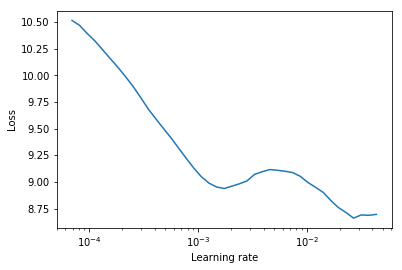

In [0]:
#find the best learning rate
model = Resnet(BasicBlock,[9,9,9])
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-4)
optimizer = optim.SGD(model.parameters(), lr=1e-5, weight_decay=1e-4,momentum=0.95)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(dataloaders['train'], end_lr=100, num_iter=100)
lr_finder.plot()

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


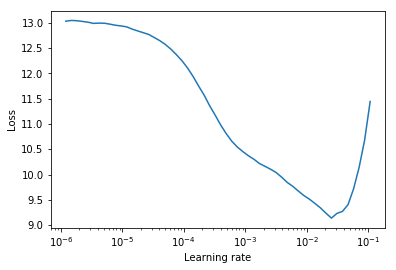

In [0]:
#find the best learning rate
model = Resnet(BasicBlock,[9,9,9])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-4)
#optimizer = optim.SGD(model.parameters(), lr=1e-5, weight_decay=0,momentum=0.85)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(dataloaders['train'], end_lr=100, num_iter=100)
lr_finder.plot()

In [30]:
#train a Resnet56 with batchsize 32
model= Resnet(BasicBlock,[9,9,9])
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, weight_decay=1e-3,momentum=0.95)
exp_lr_scheduler = lr_scheduler.CyclicLR(optimizer,base_lr=0.002,max_lr=0.01)
model = train_model(model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=200)

Epoch 0/199
----------
train Loss: 5.5694 Acc: 0.0102
val Loss: 5.5717 Acc: 0.0007

Epoch 1/199
----------
train Loss: 5.2624 Acc: 0.0180
val Loss: 5.5150 Acc: 0.0013

Epoch 2/199
----------
train Loss: 5.1625 Acc: 0.0255
val Loss: 5.7128 Acc: 0.0025

Epoch 3/199
----------
train Loss: 5.0700 Acc: 0.0323
val Loss: 6.0767 Acc: 0.0049

Epoch 4/199
----------
train Loss: 4.9913 Acc: 0.0380
val Loss: 5.7429 Acc: 0.0058

Epoch 5/199
----------
train Loss: 4.9188 Acc: 0.0434
val Loss: 6.1126 Acc: 0.0027

Epoch 6/199
----------
train Loss: 4.8497 Acc: 0.0488
val Loss: 6.5147 Acc: 0.0029

Epoch 7/199
----------
train Loss: 4.7894 Acc: 0.0530
val Loss: 6.3710 Acc: 0.0050

Epoch 8/199
----------
train Loss: 4.7277 Acc: 0.0590
val Loss: 6.5432 Acc: 0.0021

Epoch 9/199
----------
train Loss: 4.6734 Acc: 0.0647
val Loss: 6.3471 Acc: 0.0058

Epoch 10/199
----------
train Loss: 4.6238 Acc: 0.0711
val Loss: 6.9123 Acc: 0.0028

Epoch 11/199
----------
train Loss: 4.5726 Acc: 0.0764
val Loss: 7.2389 Acc

KeyboardInterrupt: ignored